# Stationary state

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
import solve_kolmogorov
import Hypergraphs

from scipy.integrate import solve_ivp

In [2]:
"""Complete case test."""
# setup
nsims = 10 # number of simulation runs
time_max = 20  # maximum time duration TODO: can increase to 100 if necessary

N = 100
g = Hypergraphs.CompleteHypergraph(N)

I0 = 10 # number of initial infected
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}, time_max = {time_max}\n")

Setup: 

	H = CompleteHypergraph, N = 100, I0 = 10

	beta1 = 0.02, beta2 = 0.0004, mu = 1, time_max = 20



In [ ]:
i_max = 10
j_max = 10

k_star = np.zeros((i_max, j_max)) # to store the values k^* = E[X(t_max)]

eps = 1e-1 # shift for esp to not start with 0 !

beta1_vec = (np.array(list(range(i_max))) + eps) / N
beta2_vec = (np.array(list(range(j_max))) + eps) / (N**2)

beta1_vec

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091])

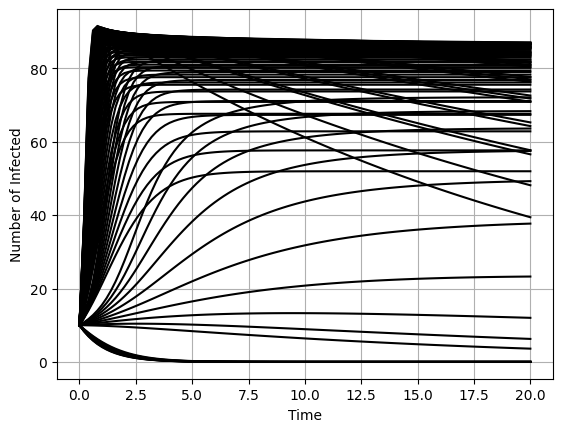

In [28]:
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

t_span = (0.0, time_max)
npoints = 101

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):

        # times t_i to evaluate in, get saved in sol.t
        t_eval = np.linspace(t_span[0], t_span[1], npoints)
        ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(
            g, beta1, beta2, mu)

        def f_ode(t, p):
            return ode_system_complete(t, p)

        sol = solve_ivp(f_ode, 
                        t_span, 
                        p0, 
                        t_eval=t_eval,
                        method="RK45"
        )
        expected_values = solve_kolmogorov.calculate_expected_values(sol)

        k_star[i, j] = expected_values[-1]

        plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# TODO: if derivative is negative then stop and put 0
# postprocess it:
# eps = 1e-6
# Take finite diference: E[X(t_final)] - E[X(t_final - delta_t)] < eps

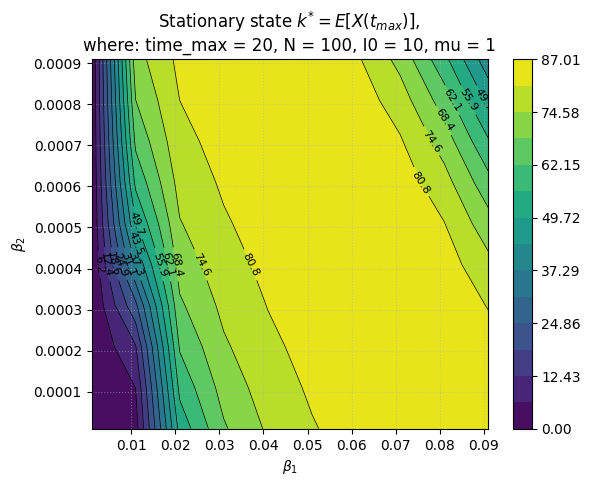

In [ ]:
B1, B2 = np.meshgrid(beta1_vec, beta2_vec)
plt.figure()
levels = np.linspace(k_star.min(), k_star.max(), 15) # TODO: set levels

contourf_plot = plt.contourf(B1, B2, k_star.T, levels=levels, cmap='viridis') # use k_star.T!!
contour_plot = plt.contour(B1, B2, k_star.T, levels=contourf_plot.levels, colors='k', linewidths=0.5)

plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%.1f')

cbar = plt.colorbar(contourf_plot)
cbar.set_label(r'')

plt_title = r'Stationary state $k^{*} = E[X(t_{max})]$, '
plt_title += f"\nwhere: time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}"
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title(plt_title)
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state-contour.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()